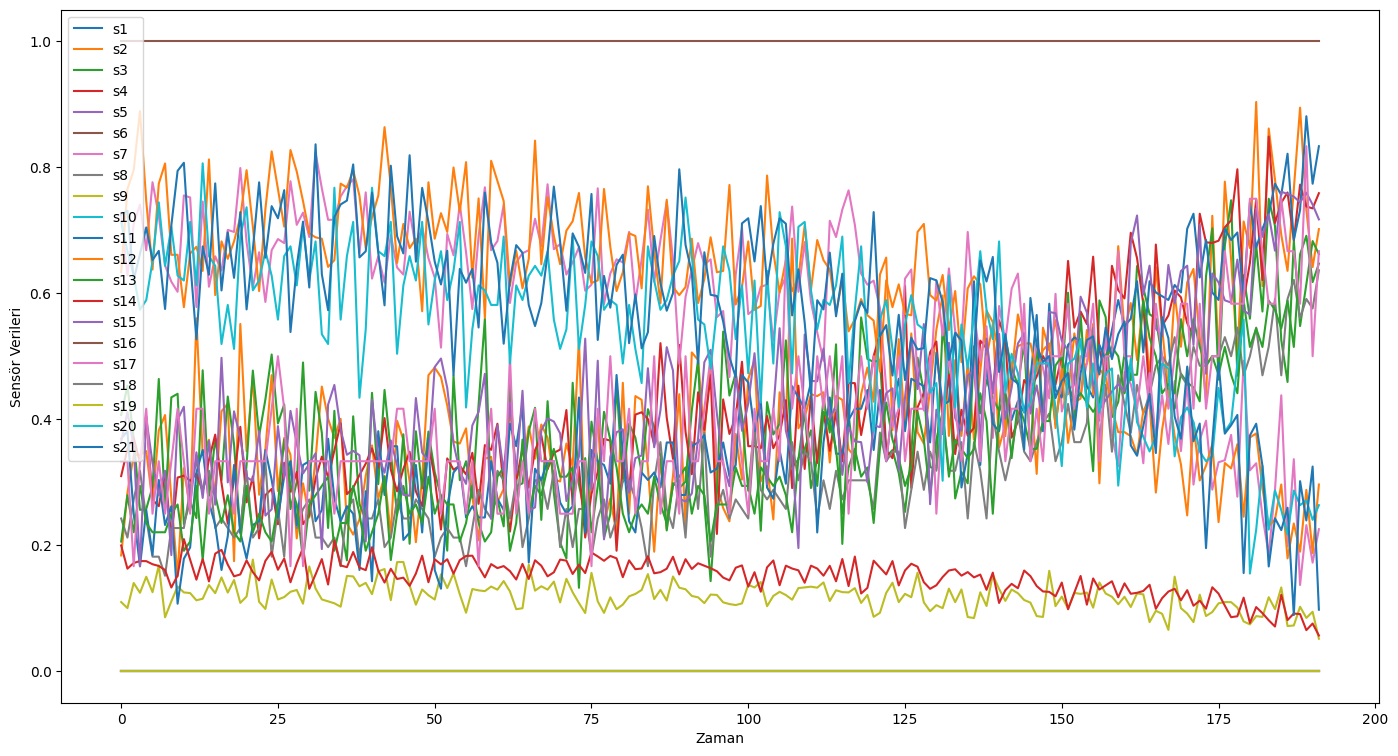

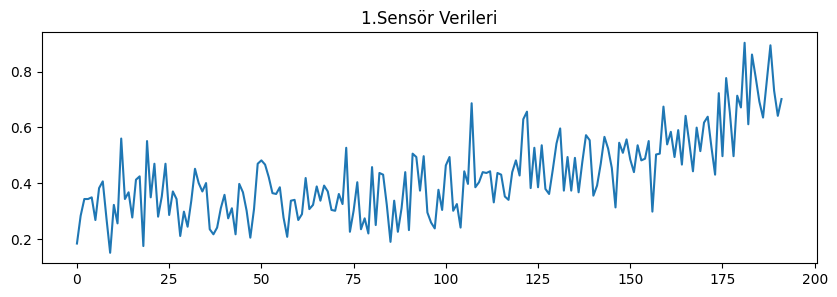

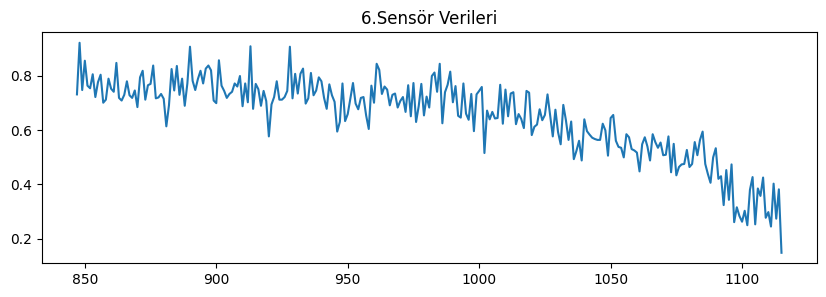

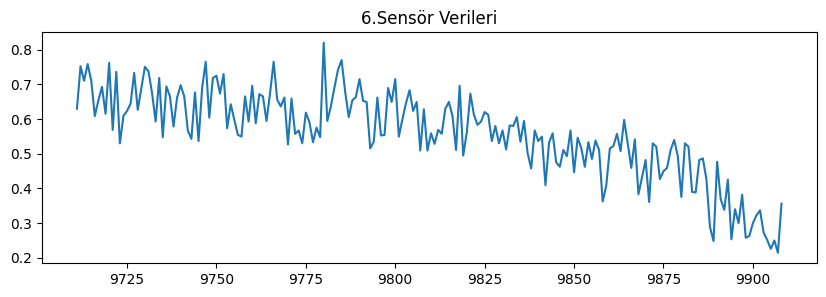

'\nSensör 6 gözlemlerini ID 1 ve ID 50 için çizdik.\nHer iki gözlem de döngü sayısı arttıkça aşağı doğru bir eğilim göstermektedir.\nSensör değerlerinin belirli bir değere yaklaştığını görebiliriz, bu durumda uçağın yakında çalışmama riski vardır.\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
egitim = pd.read_csv(r"D:\users\m_ozdemir15\Desktop\Okul\Y.Lisans\2.Dönem\Makine Öğrenmesi\Proje\cmapss\train_FD001.txt", sep='\s+', header=None)
test = pd.read_csv(r"D:\users\m_ozdemir15\Desktop\Okul\Y.Lisans\2.Dönem\Makine Öğrenmesi\Proje\cmapss\test_FD001.txt", sep='\s+', header=None)
y_test = pd.read_csv(r"D:\users\m_ozdemir15\Desktop\Okul\Y.Lisans\2.Dönem\Makine Öğrenmesi\Proje\cmapss\RUL_FD001.txt", sep='\s+', header=None)

sutun_adlari = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

egitim.columns = sutun_adlari
test.columns = sutun_adlari

egitim.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)

#Rul datası Nan Dataları drop etme süreci
y_test.dropna(axis=1, inplace=True)
y_test.head()
y_test.head() 

"""
Rul değeri 30 ve altı olanlar arızalı olarak değerlendirilecek ve "1" yazılacak arızalı 
olmayanlar "0" olarak değerlendirilecek

Veri setini kimliğene ve döngülere göre sıralanacak,
böylece her motorun kendi değerleri sıralanıp tek bir yerde listelenecek. sort_values() fonksiyonunu  kullanacağız.
"""

egitim.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)

#DATA İŞLEME ADIMI

#Her motor kimliği için maksimum döngü sayısına çıkarma.
rul = pd.DataFrame(egitim.groupby('id')['cycle'].max()).reset_index()

# Sütunları adlandırma ve eğitim verileri ile birleştirme.
rul.columns = ['id', 'max']
egitim = egitim.merge(rul, on=['id'], how='left')

# kalan faydalı ömrü hesaplamak için mevcut döngüyü maksimumdan (maksimum döngü sayısından) çıkar.
egitim['RUL'] = egitim['max'] - egitim['cycle']

#RUL(Kalan faydalı ömür) her id için hesaplandı
egitim[['id','cycle','max','RUL']].head()

#  "max" kalan faydalı ömürü hesaplamak için kullandık artık ihtiyacımız kalmadığı için atılabilir.
egitim.drop('max', axis=1, inplace=True)

#Bir motorun w1 döngüleri içerisinde arızalanıp arızalanmayacağını gösteren bir etiket yapılacak.w1 30 dan büyükse 0 küçükse 1 olacak.
w1 = 30
egitim['w1_icinde_hata'] = np.where(egitim['RUL'] <= w1, 1, 0 )

#DATASET NORMALİZASYON ADIMI

# Döngü sütunlarının normalize edilmiş değeri için ayrı bir özellik oluşturma
egitim['cycle_norm'] = egitim['cycle']

# Fark fonksiyonunu kullanarak, bu sütunları normalizasyon sürecinden hariç tutuyoruz.
sutun_normalize = egitim.columns.difference(['id','cycle','RUL','w1_icinde_hata'])

# Sensör verilerinin 0 ile 1 arasında Min-Max normalizasyonu.
min_max_skalasi = preprocessing.MinMaxScaler()
norm_egitim = pd.DataFrame(min_max_skalasi.fit_transform(egitim[sutun_normalize]), 
                             columns=sutun_normalize, 
                             index=egitim.index)

#Normalize edilmiş ve normalize edilmemiş verileri birleştiriliyor.
birlestir_egitim= egitim[['id','cycle','RUL','w1_icinde_hata']].join(norm_egitim)
egitim = birlestir_egitim.reindex(columns = egitim.columns)
egitim.head()

#Test verilerini eğitim verileri gibi normalize ediyorum

#  MinMax normalizasyon ( 0'dan 1'e)
test['cycle_norm'] = test['cycle']

#Sadece sensör verilerini 0 ile 1 arasında Min-Max normalizasyonu yapın
norm_test = pd.DataFrame(min_max_skalasi.transform(test[sutun_normalize]), 
                            columns=sutun_normalize, 
                            index=test.index)

#Normalleştirilmiş ve normalleştirilmemiş verileri birleştirin ( 'RUL' ve 'w1_icinde_hata' olmadan).
test_birlestirilmis = test[test.columns.difference(sutun_normalize)].join(norm_test)
test = test_birlestirilmis.reindex(columns = test.columns)
test = test.reset_index(drop=True)

#Test setinde verilen maksimum döngülerin toplamını ve gerçek RUL değerlerini ekleyerek toplam RUL'ü hesaplayalım.

rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
y_test.columns = ['toplanmis_rul']

#İlgili kimlik (id), indeks 1 eklenerek elde edilebilir, çünkü indeks 0'dan başlar.
y_test['id'] = y_test.index + 1

#Test setinde verilen maksimum döngü sayısını ve gerçek RUL (Kalan Faydalı Ömür) değerlerini toplama
y_test['max'] = rul['max'] + y_test['toplanmis_rul']
y_test.drop('toplanmis_rul', axis=1, inplace=True)

# Test datası için RUL verisi üret
test = test.merge(y_test, on=['id'], how='left')
test['RUL'] = test['max'] - test['cycle']
test.drop('max', axis=1, inplace=True)

#Test verisi için 'w0' ve 'w1' etiket sütunlarını oluşturma
test['w1_icinde_hata'] = np.where(test['RUL'] <= w1, 1, 0 )
test.head()

sensor_sutun = sutun_adlari[5:]
egitim[egitim.id==1][sensor_sutun ].plot(figsize=(17, 9))
plt.xlabel('Zaman')
plt.ylabel('Sensör Verileri')
plt.show()
"""
1. Sensör değerleri numara döngüsü arttıkça artar.
6. Sensör değerleri numara döngüsü arttıkça azalır.
Diğer çoğu sensör ise ya artan ya da azalan bir eğilim sergiler.
"""
egitim[egitim.id==1][sensor_sutun[1]].plot(figsize=(10, 3))
plt.title('1.Sensör Verileri')
plt.show()
egitim[egitim.id==5][sensor_sutun[6]].plot(figsize=(10, 3))
plt.title('6.Sensör Verileri')
plt.show()
"""
ID 1 ve ID 5 için sensör 1 gözlemlerini çizdik.
Her iki gözlem de döngü sayısı arttıkça yukarı doğru bir eğilim göstermektedir.
"""
egitim[egitim.id==50][sensor_sutun[6]].plot(figsize=(10, 3))
plt.title('6.Sensör Verileri')
plt.show()
"""
Sensör 6 gözlemlerini ID 1 ve ID 50 için çizdik.
Her iki gözlem de döngü sayısı arttıkça aşağı doğru bir eğilim göstermektedir.
Sensör değerlerinin belirli bir değere yaklaştığını görebiliriz, bu durumda uçağın yakında çalışmama riski vardır.
"""
